In [ ]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [ ]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [ ]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [ ]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [ ]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [ ]:
print(os.getcwd())

In [ ]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_SingleStep_v6 import RNN_GRU

In [ ]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [ ]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

In [ ]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

# KS System

In [ ]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # autoencoder directory
    ae_idx = '009'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

In [ ]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

In [ ]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

In [ ]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [ ]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

In [ ]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [ ]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [ ]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [ ]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

In [ ]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [ ]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [ ]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 3
    dt_rnn = 0.1
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    stddev_multiplier = 3
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [ ]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [ ]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_dict = {
        'eta_begin':0.0001,
        'eta_high':0.001,
        'eta_low':0.00001
    }
    epochs = 2000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 0.025

    # saving training params
    training_specific_params = {
        'learning_rate_dict':learning_rate_dict,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_dict = tparams_dict['learning_rate_dict']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [ ]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [ ]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [ ]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**7]*1
    timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    stddev = fRMS*timeMeanofSpaceRMS
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func='linear',
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func='linear',
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

In [ ]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs)*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs)*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=[0],
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [30]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    # the below two lines are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)
    
    # sigmoid annealing lr schedule
    lrschedule_cb = sigmoidWarmupAndDecayLRSchedule(
        eta_begin=learning_rate_dict['eta_begin'],
        eta_high=learning_rate_dict['eta_high'],
        eta_low=learning_rate_dict['eta_low'],
        warmup=20,
        expected_epochs=50,
        g_star=0.999,
        f_star=0.001
    )

    # training the network
    savelosses_cb.update_offset(epochs - num_epochs_left)
    
    history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
        epochs=num_epochs_left,
        batch_size=batch_size,
        # validation_split=val_split/(train_split+val_split),
        validation_data=(val_data_rnn_input, val_data_rnn_output),
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb, lrschedule_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])

96/96 [==============================] - ETA: 0s - loss: 5.3815e-04 - tot_time: 1h 58m 33.7s

Epoch 193: val_loss did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 37s 387ms/step - loss: 5.3815e-04 - val_loss: 5.6556e-04
Epoch 194/2000
96/96 [==============================] - ETA: 0s - loss: 5.3784e-04 - tot_time: 1h 59m 11.2s

Epoch 194: val_loss improved from 0.00057 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 38s 391ms/step - loss: 5.3784e-04 - val_loss: 5.6454e-04
Epoch 195/2000
96/96 [==============================] - ETA: 0s - loss: 5.3767e-04 - tot_time: 1h 59m 49.1s

Epoch 195: val_loss improved from 0.00056 to 

Epoch 212/2000
96/96 [==============================] - ETA: 0s - loss: 5.3360e-04 - tot_time: 2h 10m 9.9s

Epoch 212: val_loss improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.3360e-04 - val_loss: 5.6085e-04
Epoch 213/2000
96/96 [==============================] - ETA: 0s - loss: 5.3338e-04 - tot_time: 2h 10m 46.2s

Epoch 213: val_loss did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.3338e-04 - val_loss: 5.6119e-04
Epoch 214/2000
96/96 [==============================] - ETA: 0s - loss: 5.3327e-04 - tot_time: 2h 11m 22.5s

Epoch 214: val_loss improved fr

96/96 [==============================] - ETA: 0s - loss: 5.2940e-04 - tot_time: 2h 21m 39.2s

Epoch 231: val_loss improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.2940e-04 - val_loss: 5.5691e-04
Epoch 232/2000
96/96 [==============================] - ETA: 0s - loss: 5.2929e-04 - tot_time: 2h 22m 15.6s

Epoch 232: val_loss improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 379ms/step - loss: 5.2929e-04 - val_loss: 5.5680e-04
Epoch 233/2000
96/96 [=============================

Epoch 250/2000
96/96 [==============================] - ETA: 0s - loss: 5.2557e-04 - tot_time: 2h 33m 9.8s

Epoch 250: val_loss did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.2557e-04 - val_loss: 5.5402e-04
Epoch 251/2000
96/96 [==============================] - ETA: 0s - loss: 5.2546e-04 - tot_time: 2h 33m 46.2s

Epoch 251: val_loss improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 379ms/step - loss: 5.2546e-04 - val_loss: 5.5272e-04
Epoch 252/2000
96/96 [==============================] - ETA: 0s - loss: 5.2537e-04 - tot_time: 2h 34m 22.6s

Epoch 252: val_loss did not imp

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 377ms/step - loss: 5.2179e-04 - val_loss: 5.5018e-04
Epoch 271/2000
96/96 [==============================] - ETA: 0s - loss: 5.2169e-04 - tot_time: 2h 45m 51.1s

Epoch 271: val_loss improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.2169e-04 - val_loss: 5.4998e-04
Epoch 272/2000
96/96 [==============================] - ETA: 0s - loss: 5.2155e-04 - tot_time: 2h 46m 27.4s

Epoch 272: val_loss improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rk

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 377ms/step - loss: 5.1839e-04 - val_loss: 5.4883e-04
Epoch 291/2000
96/96 [==============================] - ETA: 0s - loss: 5.1806e-04 - tot_time: 2h 57m 55.8s

Epoch 291: val_loss improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 377ms/step - loss: 5.1806e-04 - val_loss: 5.4699e-04
Epoch 292/2000
96/96 [==============================] - ETA: 0s - loss: 5.1793e-04 - tot_time: 2h 58m 31.9s

Epoch 292: val_loss did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [=========

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 380ms/step - loss: 5.1488e-04 - val_loss: 5.4430e-04
Epoch 311/2000
96/96 [==============================] - ETA: 0s - loss: 5.1477e-04 - tot_time: 3h 10m 1.6s

Epoch 311: val_loss did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.1477e-04 - val_loss: 5.4655e-04
Epoch 312/2000
96/96 [==============================] - ETA: 0s - loss: 5.1474e-04 - tot_time: 3h 10m 37.9s

Epoch 312: val_loss did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 379ms/step - loss: 5.1474e-04 - val_loss: 5.4454e-04
Epoch 313/2000
96/96 [

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 380ms/step - loss: 5.1175e-04 - val_loss: 5.4183e-04
Epoch 331/2000
96/96 [==============================] - ETA: 0s - loss: 5.1169e-04 - tot_time: 3h 22m 8.3s

Epoch 331: val_loss did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.1169e-04 - val_loss: 5.4236e-04
Epoch 332/2000
96/96 [==============================] - ETA: 0s - loss: 5.1153e-04 - tot_time: 3h 22m 44.6s

Epoch 332: val_loss did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.1153e-04 - val_loss: 5.4336e-04
Epoch 333/2000
96/96 [

Epoch 351/2000
96/96 [==============================] - ETA: 0s - loss: 5.0885e-04 - tot_time: 3h 34m 13.4s

Epoch 351: val_loss did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 377ms/step - loss: 5.0885e-04 - val_loss: 5.4002e-04
Epoch 352/2000
96/96 [==============================] - ETA: 0s - loss: 5.0852e-04 - tot_time: 3h 34m 49.6s

Epoch 352: val_loss did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 377ms/step - loss: 5.0852e-04 - val_loss: 5.4034e-04
Epoch 353/2000
96/96 [==============================] - ETA: 0s - loss: 5.0850e-04 - tot_time: 3h 35m 25.9s

Epoch 353: val_loss did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_0

Epoch 371/2000
96/96 [==============================] - ETA: 0s - loss: 5.0599e-04 - tot_time: 3h 46m 18.4s

Epoch 371: val_loss improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.0599e-04 - val_loss: 5.3724e-04
Epoch 372/2000
96/96 [==============================] - ETA: 0s - loss: 5.0577e-04 - tot_time: 3h 46m 54.7s

Epoch 372: val_loss improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 379ms/step - loss: 5.0577e-04 - val_loss: 5.3721e-04
Epoch 373/2000
96/96 [==============

Epoch 391/2000
96/96 [==============================] - ETA: 0s - loss: 5.0338e-04 - tot_time: 3h 58m 25.5s

Epoch 391: val_loss improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.0338e-04 - val_loss: 5.3596e-04
Epoch 392/2000
96/96 [==============================] - ETA: 0s - loss: 5.0316e-04 - tot_time: 3h 59m 1.9s

Epoch 392: val_loss did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 378ms/step - loss: 5.0316e-04 - val_loss: 5.3608e-04
Epoch 393/2000
96/96 [==============================] - ETA: 0s - loss: 5.0312e-04 - tot_time: 3h 59m 38.2s

Epoch 393: val_loss did not imp

Epoch 412/2000
96/96 [==============================] - ETA: 0s - loss: 5.0080e-04 - tot_time: 4h 11m 7.5s

Epoch 412: val_loss did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 379ms/step - loss: 5.0080e-04 - val_loss: 5.3427e-04
Epoch 413/2000
96/96 [==============================] - ETA: 0s - loss: 5.0064e-04 - tot_time: 4h 11m 43.8s

Epoch 413: val_loss improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 36s 379ms/step - loss: 5.0064e-04 - val_loss: 5.3407e-04
Epoch 414/2000
96/96 [==============================] - ETA: 0s - loss: 5.0063e-04 - tot_time: 4h 12m 20.2s

Epoch 414: val_loss did not imp

Epoch 432/2000
96/96 [==============================] - ETA: 0s - loss: 4.9849e-04 - tot_time: 4h 23m 16.4s

Epoch 432: val_loss did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 38s 391ms/step - loss: 4.9849e-04 - val_loss: 5.3307e-04
Epoch 433/2000
96/96 [==============================] - ETA: 0s - loss: 4.9852e-04 - tot_time: 4h 23m 53.9s

Epoch 433: val_loss did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 37s 391ms/step - loss: 4.9852e-04 - val_loss: 5.3314e-04
Epoch 434/2000
96/96 [==============================] - ETA: 0s - loss: 4.9839e-04 - tot_time: 4h 24m 31.3s

Epoch 434: val_loss did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_0

Epoch 453/2000
96/96 [==============================] - ETA: 0s - loss: 4.9615e-04 - tot_time: 4h 36m 20.8s

Epoch 453: val_loss did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 37s 381ms/step - loss: 4.9615e-04 - val_loss: 5.3174e-04
Epoch 454/2000
96/96 [==============================] - ETA: 0s - loss: 4.9626e-04 - tot_time: 4h 36m 57.3s

Epoch 454: val_loss improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 37s 381ms/step - loss: 4.9626e-04 - val_loss: 5.3067e-04
Epoch 455/2000
96/96 [==============================] - ETA: 0s - loss: 4.9618e-04 - tot_time: 4h 37m 34.1s

Epoch 455: val_loss did not im

96/96 [==============================] - ETA: 0s - loss: 4.9407e-04 - tot_time: 4h 49m 26.9s

Epoch 474: val_loss did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 38s 394ms/step - loss: 4.9407e-04 - val_loss: 5.3105e-04
Epoch 475/2000
96/96 [==============================] - ETA: 0s - loss: 4.9405e-04 - tot_time: 4h 50m 4.9s

Epoch 475: val_loss did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
96/96 [==============================] - 38s 396ms/step - loss: 4.9405e-04 - val_loss: 5.3110e-04
Epoch 476/2000
96/96 [==============================] - ETA: 0s - loss: 4.9403e-04 - tot_time: 4h 50m 42.7s

Epoch 476: val_loss did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/L

In [31]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

24/24 [==============================] - 3s 104ms/step - loss: 5.2831e-04


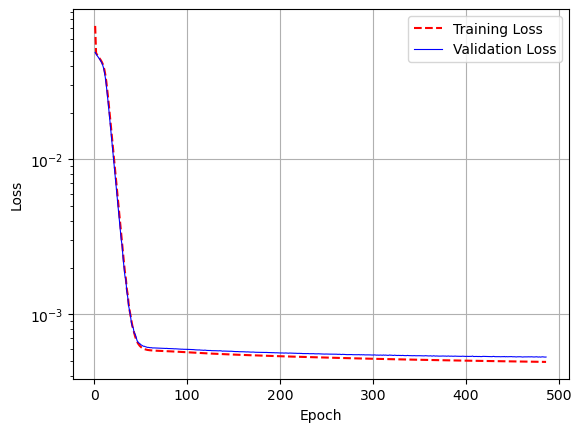

In [32]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=None
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 544


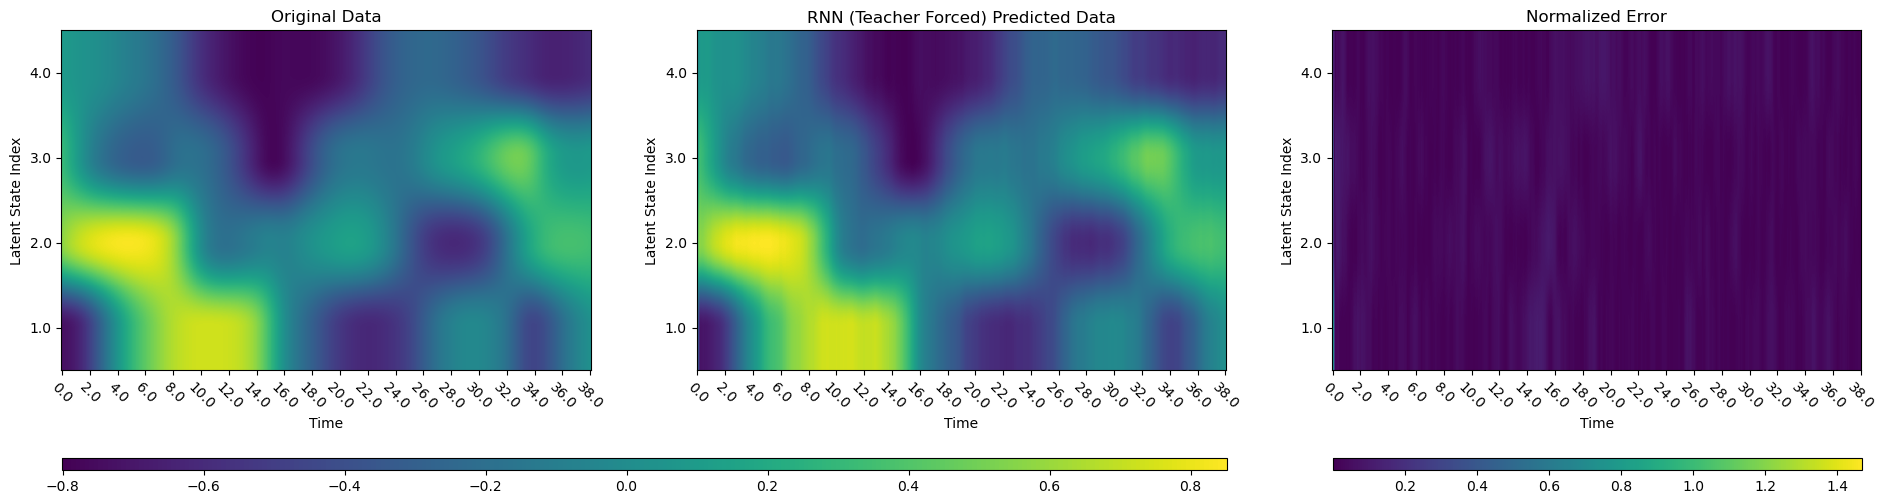

In [33]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [34]:
prediction.shape, data_out.shape

((1, 381, 4), (381, 4))